In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

### Generate synthetic spike data

In [4]:
# Create a simple single-spike signal
def generate_signal(l, spike_width, spike_std, n_spikes=1, plot=False):
    if n_spikes > 0:
        spikes = [signal.gaussian(spike_width, std=spike_std) for _ in range(n_spikes)]
        baseline = min(spikes[0])
    # Otherwise just generate one Gaussian w/ same params to get min value matching
    else:
        baseline = min(signal.gaussian(spike_width, std=spike_std))
    
    # Assemble the signal piecewise
    w = l - n_spikes * spike_width
    assert w > 0
    segments = []
    for i in range(n_spikes):
        w_split = np.random.randint(w)
        segments.append([baseline] * w_split)
        segments.append(spikes[i])
        w -= w_split
    segments.append([baseline] * w)
    
    # Return the signal, optionally plotting as well
    X = np.hstack(segments)
    if plot:
        plt.plot(X)
        plt.show()
    return X

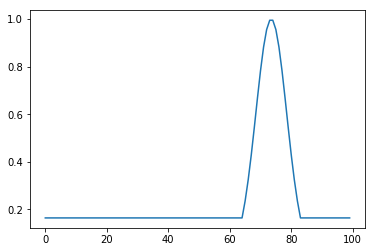

In [6]:
_ = generate_signal(100, 20, 5, n_spikes=1, plot=True)

In [7]:
# Generate a simple spike / no spike dataset
n = 1000
SIGNAL_LEN = 100
SPIKE_WIDTH = 20
SPIKE_STD = 5

Y = np.random.randint(1, 3, n) # Note: labels in {1,2}
X = np.array([generate_signal(SIGNAL_LEN, SPIKE_WIDTH, SPIKE_STD, n_spikes=y-1) for y in Y]).reshape(n, SIGNAL_LEN, 1)

Y_test = np.random.randint(1, 3, n) # Note: labels in {1,2}
X_test = np.array([generate_signal(SIGNAL_LEN, SPIKE_WIDTH, SPIKE_STD, n_spikes=y-1) for y in Y_test]).reshape(n, SIGNAL_LEN, 1)

In [8]:
X.shape

(1000, 100, 1)

### Test LSTM

In [9]:
from metal.modules import LSTMModule
from metal.end_model import EndModel

In [10]:
k = 2
embed_size = 1
hidden_size = 10

lstm_module = LSTMModule(
    embed_size,
    hidden_size,
    skip_embeddings=True,
    bidirectional=False,
    verbose=True,
    lstm_reduction="max",
)

em = EndModel(
    k=k,
    input_module=lstm_module,
    layer_out_dims=[hidden_size, k],
    optimizer="adam",
    batchnorm=True,
    seed=1,
    verbose=True,
)

em.train_model((X, Y), n_epochs=15)
score = em.score((X_test, Y_test), verbose=True)

Skipping embeddings and using direct input.

Network architecture:
Sequential(
  (0): Sequential(
    (0): LSTMModule(
      (lstm): LSTM(1, 10, batch_first=True)
    )
    (1): ReLU()
  )
  (1): Linear(in_features=10, out_features=2, bias=True)
)




[E:0]	Train Loss: 0.579



[E:1]	Train Loss: 0.297



[E:2]	Train Loss: 0.086



[E:3]	Train Loss: 0.037



[E:4]	Train Loss: 0.023



[E:5]	Train Loss: 0.016



[E:6]	Train Loss: 0.668



[E:7]	Train Loss: 0.302



[E:8]	Train Loss: 0.050



[E:9]	Train Loss: 0.032



[E:10]	Train Loss: 0.024



[E:11]	Train Loss: 0.019



[E:12]	Train Loss: 0.017



[E:13]	Train Loss: 0.015



[E:14]	Train Loss: 0.013
Finished Training
Accuracy: 1.000
        y=1    y=2   
 l=1    488     0    
 l=2     0     512   
